# Solutions for hands-on session 2

In [5]:
import nixio
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina'] # only for users with a high resolution display

def threshold_crossings(data, threshold=0.0, flank="rising"):
    """
    Returns the indices of threshold crossings in a given signal.
    :param data: the signal.
    :param threshold: the threshold. Default 0.0.
    :param flank: accepts values {"rising", "falling"} with "rising" being the default.

    :return: the indices of the threshold crossings.
    """
    flanks = ["rising", "falling"]
    if flank.lower() not in flanks:
        flank = flanks[0]
    data = np.squeeze(data)
    if len(data.shape) > 1:
        raise Exception("trace must be 1-D")
    shifted_data = np.hstack((0, data[0:-1]))
    if flank.lower() == "rising":
        crossings = (data > threshold) & (shifted_data <= threshold)
    else:
        crossings = (data < threshold) & (shifted_data >= threshold)
    positions = np.nonzero(crossings)[0]

    return positions


def butter_lowpass(highcut, fs, order=5):
    """ Creates a butterworth lowpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='low')

    return b, a


def butter_highpass(lowcut, fs, order=5):
    """ Creates a butterworth highpass filter.

    Args:
        highcut (double): the cutoff frequency in Hz
        fs (int): the sampling rate of the data
        order (int, optional): the order of the low-pass filter. Defaults to 5.

    Returns:
        b, a (np.array): the filter coefficients
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='high')

    return b, a


def detect_spikes(data, time, fs):
    # filter the data a bit
    hpb , hpa = butter_highpass(2.5, fs, 5)
    lpb , lpa = butter_lowpass(100, fs, 5)

    spike_times = []
    spike_channels = [] 
    for i in range(data.shape[1]):
        y = signal.lfilter(hpb, hpa, data[:, i])
        y = signal.lfilter(lpb, lpa, y)
        
        # detect spikes
        spike_indices = threshold_crossings(y, 0.5)
        times = time[spike_indices]
        spike_times.extend(times)
        spike_channels.extend(np.ones_like(times) * i)

    spike_positions = np.vstack((np.array(spike_times), spike_channels)).T  # we need to have the time along the first dimension, as in the data
    return spike_positions

## Exercise 1: Tagging a single segment in 1-D

In [6]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadWrite)
block = nixfile.blocks["session 1"]

tag = block.create_tag("stimulus", "nix.segment.stimulus", position=[3.0])
tag.extent = [4.5]
tag.references.append(block.data_arrays["intracellular data"])
tag.references.append(block.data_arrays["spike times"])

nixfile.close()

## Exercise 2: Retrieving tagged data

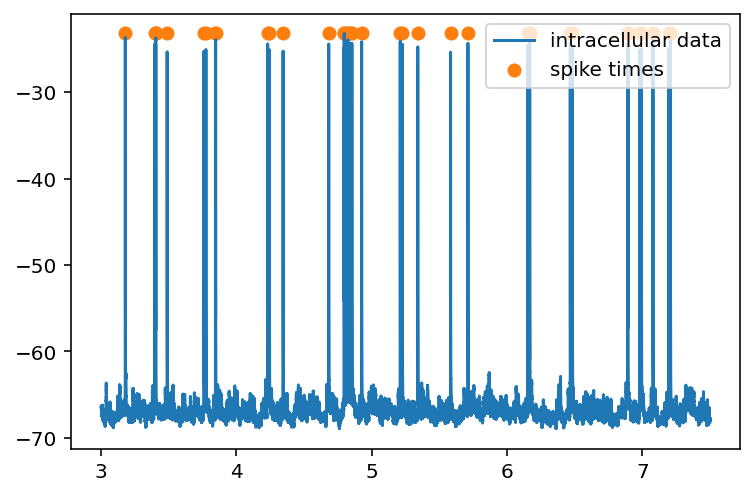

In [7]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadOnly)

block = nixfile.blocks[0]
tag = block.tags["stimulus"]

intra_data = tag.tagged_data("intracellular data")[:]
time = tag.references["intracellular data"].dimensions[0].axis(len(intra_data), start_position=tag.position[0])
spike_times_data = tag.tagged_data("spike times")[:]

plt.plot(time, intra_data, label="intracellular data")
plt.scatter(spike_times_data, np.ones(len(spike_times_data)) * np.max(intra_data), label="spike times", color="tab:orange")
plt.legend()

nixfile.close()

## Exercise 3: Tagging in 2-D

In [8]:
nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.ReadWrite)

block = nixfile.blocks["session 1"]
lfp_array = block.data_arrays["lfp"]
max_time = lfp_array.shape[0] * lfp_array.dimensions[0].sampling_interval
v4_tag = block.create_tag("V4 electrodes", "nix.segment", position=[0.0, 0])
v4_tag.extent = [max_time, 5]
v4_tag.references.append(lfp_array)

v5_tag = block.create_tag("V5 electrodes", "nix.segment", position=[0.0, 5])
v5_tag.extent = [max_time, 5]
v5_tag.references.append(lfp_array)
nixfile.close()


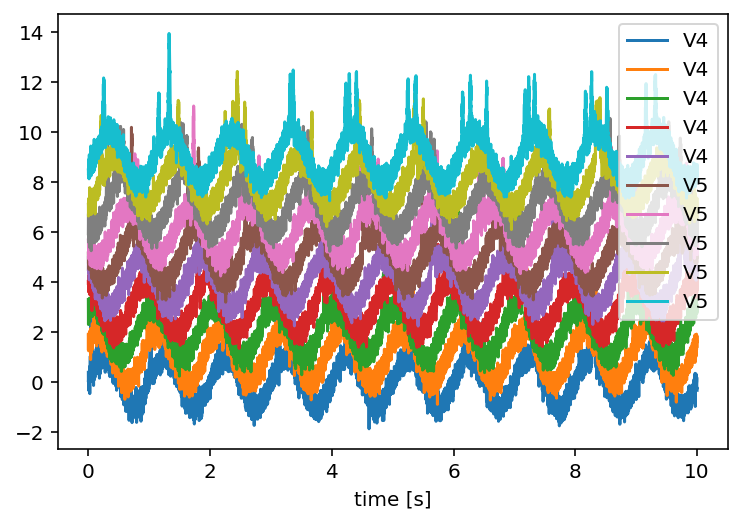

In [9]:
nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.ReadOnly)

block = nixfile.blocks["session 1"]

v4_tag = block.tags["V4 electrodes"]
v5_tag = block.tags["V5 electrodes"]

v4_data = v4_tag.tagged_data("lfp")
v5_data = v5_tag.tagged_data("lfp")
time = v4_tag.references["lfp"].dimensions[0].axis(v4_data.shape[0])

for i in range(v4_data.shape[1]):
    plt.plot(time, v4_data[:, i] + i, label="V4")

for i in range(v5_data.shape[1]):
    plt.plot(time, v5_data[:, i] + i + v4_data.shape[1], label="V5")

plt.xlabel("time [s]")
plt.legend()

nixfile.close()

## Exercise 4: Tagging multiple points in 1-D

In [10]:
nixfile = nixio.File.open("intracellular_data.nix", nixio.FileMode.ReadWrite)
block = nixfile.blocks["session 1"]

spike_times_array = block.data_arrays["spike times"]
intra_array = block.data_arrays["intracellular data"]

mt = block.create_multi_tag("Spike detection", "nix.spike_detection", positions=spike_times_array)
mt.references.append(intra_array)

nixfile.close()

TypeError: create_multi_tag() got an unexpected keyword argument 'positions_array'

In [14]:
mt.references.append(intra_array)

nixfile.close()

## Exercise 5: Tagging multiple events in 2-D

In [15]:
nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.ReadWrite)
block = nixfile.blocks["session 1"]
data = block.data_arrays["lfp"][:]
time = np.array(block.data_arrays["lfp"].dimensions[0].axis(data.shape[0]))
fs = 1./block.data_arrays["lfp"].dimensions[0].sampling_interval

spike_positions = detect_spikes(data, time, fs)

# store the spike positions in a DataArray
positions_array = block.create_data_array("spike positions", "nix.event_positions.2d", data=spike_positions)
positions_array.append_set_dimension()
positions_array.append_set_dimension()

# create the MultiTag
mt = block.create_multi_tag("Spike detection", "nix.spike_detection", positions=positions_array)
mt.references.append(block.data_arrays["lfp"])

nixfile.close()

True (1, 1) [[2.05351087]]
True (1, 1) [[1.78494931]]
True (1, 1) [[1.78722671]]
True (1, 1) [[2.57400486]]
True (1, 1) [[2.75865224]]
True (1, 1) [[2.36260392]]
True (1, 1) [[3.07389282]]
True (1, 1) [[1.47422983]]
True (1, 1) [[2.95488157]]
True (1, 1) [[2.6012469]]
True (1, 1) [[3.07570233]]
True (1, 1) [[1.98422037]]
True (1, 1) [[2.85979461]]
True (1, 1) [[3.48068821]]
True (1, 1) [[2.82262336]]
True (1, 1) [[2.74483941]]
True (1, 1) [[2.39074234]]
True (1, 1) [[2.66603638]]
True (1, 1) [[1.74942344]]
True (1, 1) [[3.32336934]]
True (1, 1) [[3.15038678]]
True (1, 1) [[1.76245061]]
True (1, 1) [[2.75719129]]
True (1, 1) [[1.82883478]]
True (1, 1) [[2.58735832]]
True (1, 1) [[2.47864034]]
True (1, 1) [[1.99806796]]
True (1, 1) [[2.20561229]]
True (1, 1) [[3.08335632]]
True (1, 1) [[2.387652]]
True (1, 1) [[2.75031916]]
True (1, 1) [[2.81122346]]
True (1, 1) [[1.82584805]]
True (1, 1) [[2.7884956]]
True (1, 1) [[2.1695677]]
True (1, 1) [[2.51633159]]
True (1, 1) [[1.88141145]]
True (

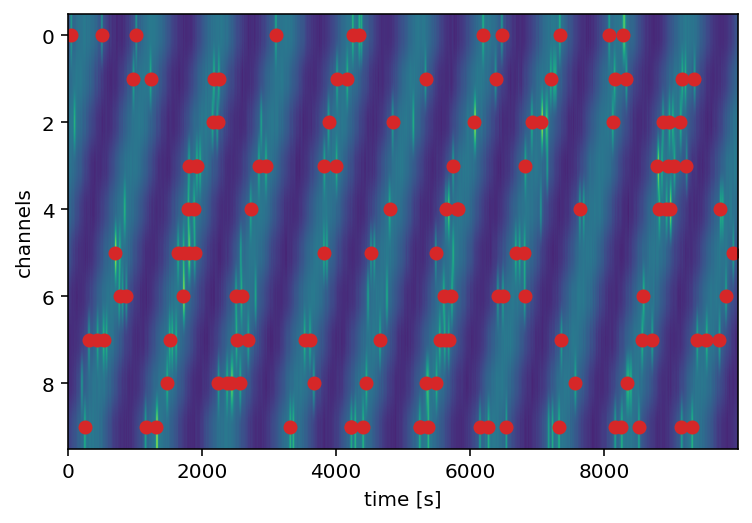

In [ ]:
def get_label(obj):
    """ Returns a string that can be used as an axis label. Constructs the label from DataArray or Dimension objects.

    Args:
        obj (nixio.DataArray or nixio.Dimension): the object of which an axis label should be created.

    Returns:
        string: The label incling unit, if given. Empty string for invalid objects
    """
    label = ""
    if isinstance(obj, (nixio.DataArray, nixio.SampledDimension, nixio.RangeDimension)):
        label = "%s %s" % (obj.label, ("" if obj.unit is None else "[%s]" % obj.unit))
    elif isinstance(obj, (nixio.SetDimension)) and hasattr(obj, "label"):
        label = obj.label

    return label


nixfile = nixio.File.open("lfp_fake.nix", nixio.FileMode.ReadWrite)
block = nixfile.blocks["session 1"]

mt = block.multi_tags["Spike detection"]
lfp_array = mt.references[0]
data = lfp_array[:]
sampling_interval = lfp_array.dimensions[0].sampling_interval
spike_pos = mt.positions[:]

for i in range(mt.positions.shape[0]):
    dv = mt.tagged_data(i, "lfp")
    print(dv.valid, dv.data_extent, dv[:])

plt.imshow(data.T, aspect="auto")
plt.scatter(spike_pos[:, 0] / sampling_interval, spike_pos[:, 1], color="tab:red")
plt.xlabel(get_label(lfp_array.dimensions[0]))
plt.ylabel("channels")

nixfile.close()